<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/02%20-%20DWH_Spark_ClickHouse/spark_clickhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Описание задачи ##
Поработаем с данными классифайда. Обработаем данные в Spark и настроим поставку данных в ClickHouse через интеграционные таблицы, а затем выполним несколько расчетов, чтобы ответить на вопросы бизнеса.
#### Доступные таблицы ###
**adverts_data** – данные с характеристиками объявлений:
- *execution_date*	дата, на которую была выгрузка по объявлениям live
- *advert_id*	id объявления
- *mark*	марка машины
- *model*	модель машины
- *price*	цена машины
- *year*	год машины
- *fuel*	тип топлива
- *color*	цвет
- *transmission*	коробка передач
- *body*	тип кузова авто
- *country*	страна
**live_adverts** – данные с текущими объявлениями:
- *execution_date*	дата, на которую была выгрузка по объявлениям live
- *advert_id*	id объявления
- *region*	регион объявления
- *user_id*	глобальный ID пользователя (ссылка на user_passports.global_id))
- *platform*	платформа подачи
**user_passports** – данные с характеристиками пользователей:
- *global_id*	глобальный ID пользователя
- *user_type_name*	тип пользователя

### Вычитываем данные из нескольких таблиц S3 parquet и кладем в одну широкую таблицу ###

In [ ]:
#Spark connection with S3 options
import os
import socket
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

# Указываем credentials и параметры для работы с S3
aws_access_key = "key"
aws_secret_key = "secret_key"
s3_bucket = "kc-hardda-projects"
s3_endpoint_url = "https://storage.yandexcloud.net"

# Выберем название своей рабочей директории
working_directory = '/aleksey_fomin/'

# Укажем данные для настройки кластера Spark и подключения к нему
APACHE_MASTER_IP = socket.gethostbyname("apache-spark-master-0.apache-spark-headless.apache-spark.svc.cluster.local")
APACHE_MASTER_URL = f"spark://{APACHE_MASTER_IP}:7077"
POD_IP = os.environ["MY_POD_IP"]
SPARK_APP_NAME = f"spark-{os.environ['HOSTNAME']}"
JARS = """/nfs/env/lib/python3.8/site-packages/pyspark/jars/clickhouse-native-jdbc-shaded-2.6.5.jar,
/nfs/env/lib/python3.8/site-packages/pyspark/jars/hadoop-aws-3.3.4.jar,
/nfs/env/lib/python3.8/site-packages/pyspark/jars/aws-java-sdk-bundle-1.12.433.jar
"""
MEM = "1024m"
CORES = 1
# Создадим сессию Spark
spark = SparkSession.\
        builder.\
        appName(SPARK_APP_NAME).\
        master(APACHE_MASTER_URL).\
        config("spark.executor.memory", MEM).\
        config("spark.jars", JARS).\
        config("spark.executor.cores", CORES).\
        config("spark.driver.host", POD_IP).\
        config("spark.hadoop.fs.s3a.access.key", aws_access_key). \
        config("spark.hadoop.fs.s3a.secret.key", aws_secret_key). \
        config("fs.s3a.endpoint", "https://storage.yandexcloud.net").  \
        config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem"). \
        config("spark.hadoop.fs.s3a.path.style.access", True). \
        config("spark.hadoop.fs.s3a.committer.name", "directory"). \
        config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider"). \
        getOrCreate()

24/05/29 10:53:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [ ]:
# Читаем файлы с исходными данными
df_adverts_all = spark.read.parquet('s3a://kc-hardda-projects/shared/adverts_data.parquet')
df_live_adverts = spark.read.parquet('s3a://kc-hardda-projects/shared/live_adverts.parquet')
df_user_passports = spark.read.parquet('s3a://kc-hardda-projects/shared/user_passports.parquet')

# Джойним все три таблицы для получения широкой плоской таблицы, с которой будет удобно работать в ClickHouse
df_flat = df_live_adverts.join(df_adverts_all, on=['execution_date', 'advert_id'], how='left') \
                   .join(df_user_passports, df_live_adverts['user_id'] == df_user_passports['global_id'], how='left')

# Записываем результат в S3
df_flat.coalesce(1).write.format("parquet").save(rf"s3a://{s3_bucket}{working_directory}flat_table.parquet", mode='overwrite')

# Если необходимо сохранить файл локально, это можно сделать так
#pandas_df = df_flat.coalesce(1).toPandas()
#pandas_df.to_parquet('flat_table.parquet')

In [ ]:
# Создадим подключение к S3 https://storage.yandexcloud.net и посмотрим, на созданный parquet
import boto3
from botocore.exceptions import NoCredentialsError
# Инициализация клиента S3 с указанием конечной точки
s3 = boto3.client('s3',
                  aws_access_key_id=aws_access_key,
                  aws_secret_access_key=aws_secret_key,
                  endpoint_url=s3_endpoint_url)

In [ ]:
response = s3.list_objects_v2(Bucket=s3_bucket, Prefix=r'aleksey_fomin') # Prefix - фильтр по имени, чтоб видеть только с объекты с префиксом

# Вывод списка объектов
if 'Contents' in response:
    print(f"Objects in bucket '{s3_bucket}':")
    for obj in response['Contents']:
        print(f"- {obj['Key']}")
else:
    print(f"No objects found in bucket '{s3_bucket}'")

Objects in bucket 'kc-hardda-projects':
- aleksey_fomin/flat_table.parquet/_SUCCESS
- aleksey_fomin/flat_table.parquet/part-00000-cee1a3e7-c834-46a0-98c1-a604159fa2f7-c000.snappy.parquet


Как видно и вывода выше, parquet успешно создался

### Подготовка к переносу данных из S3 parquet в ClickHouse ###

In [ ]:
# Прочитаем сформированную parquet таблицу
parquet_path = rf"s3a://{s3_bucket}{working_directory}flat_table.parquet/*.parquet"
df_flat = spark.read.parquet(parquet_path)

In [ ]:
# Посмотрим на типы данных полей получившейся parquet таблицы
# Эта информация потребуется нам для создания таблицы в ClickHouse
df_flat.printSchema()

root
 |-- execution_date: timestamp (nullable = true)
 |-- advert_id: long (nullable = true)
 |-- region: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- platform: string (nullable = true)
 |-- mark: string (nullable = true)
 |-- model: string (nullable = true)
 |-- price: double (nullable = true)
 |-- year: double (nullable = true)
 |-- fuel: string (nullable = true)
 |-- color: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- body: string (nullable = true)
 |-- country: string (nullable = true)
 |-- global_id: long (nullable = true)
 |-- user_type_name: string (nullable = true)



In [ ]:
# Для числовых полей таблицы посмотрим на min/max значения
df_flat.describe([c[0] for c in df_flat.dtypes if c[1] in ['double', 'bigint']]).show()

+-------+--------------------+-------------------+------------------+------------------+--------------------+
|summary|           advert_id|            user_id|             price|              year|           global_id|
+-------+--------------------+-------------------+------------------+------------------+--------------------+
|  count|             2771661|            2771661|           2697258|            273389|             2607516|
|   mean|2.3769846407115048E8|1.320025433157832E8|257384.05580148433|2011.0509493798215|1.3199123690995376E8|
| stddev| 3.085388897081636E7|  8515217.182871925|1268037.7070819275|10.449449784452002|    8439031.26608308|
|    min|           126746009|          123456795|               0.0|            1900.0|           123456795|
|    max|           270356294|          151763713|            1.19E8|            2022.0|           151763713|
+-------+--------------------+-------------------+------------------+------------------+--------------------+



In [ ]:
# для текстовых полей посмотрим на число уникальных значений
df_flat.agg(*(F.countDistinct(F.col(c)).alias(c) for c in [c[0] for c in df_flat.dtypes if c[1] == 'string'])).show()

+------+--------+----+-----+----+-----+------------+----+-------+--------------+
|region|platform|mark|model|fuel|color|transmission|body|country|user_type_name|
+------+--------+----+-----+----+-----+------------+----+-------+--------------+
|    21|       5|  90|  808|   6|   22|           5|  18|     15|             3|
+------+--------+----+-----+----+-----+------------+----+-------+--------------+



In [ ]:
# Все, Spark больше не нужен
spark.stop()

### Загружаем данные в ClickHouse и создаем MATERIALIZED VIEW c движком AggregatingMergeTree ###

In [ ]:
# Импортируем используемые в работе модули
import pandas as pd
from clickhouse_driver import Client

In [ ]:
# Реквизиты для подключения к БД
user='hardda_student_alekse-fomin'
password='5d1e6116e9dec84a1da81532e3b7a8cf7affd7d68b35193d3344862ac45b7c9c'

host='clickhouse.lab.karpov.courses'
port=9000
database_rw='hardda_student_data' # БД с правами чтение и запись

In [ ]:
# Создаем соединение с БД ClickHouse

# Соединение c правами на запись
client_rw = Client(host=host, port=port, user=user,
                password=password, database=database_rw)

In [ ]:
usr_name = "aleksey_fomin"
prj_s3_ext = f'prj_s3_ext_{usr_name}' # таблица c помощью которой будем подключаться к S3
prj_main = f'prj_main_{usr_name}' # таблица для CH хранения данных из таблицы, подключенной к S3 (см выше)
prj_main_agg_view_1 = f'prj_main_{usr_name}_agg_view_1' #view_1 для решения бизнес кейса 1
prj_main_agg_view_2 = f'prj_main_{usr_name}_agg_view_2' #view_1 для решения бизнес кейса 2
prj_main_agg_view_3 = f'prj_main_{usr_name}_agg_view_3' #view_1 для решения бизнес кейса 3


In [ ]:
# создаем таблицу-подключение к S3 с учетом собранной информации о типах и диапазонах данных в полях parquet таблицы
sql_create = f"""
CREATE TABLE {database_rw}.{prj_s3_ext} (
  execution_date Date,
  advert_id UInt32,
  region LowCardinality(String),
  user_id UInt32,
  platform LowCardinality(String),
  mark LowCardinality(Nullable(String)),
  model LowCardinality(Nullable(String)),
  price Nullable(Float32),
  year Nullable(UInt16),
  fuel LowCardinality(Nullable(String)),
  color LowCardinality(Nullable(String)),
  transmission LowCardinality(Nullable(String)),
  body LowCardinality(Nullable(String)),
  country LowCardinality(Nullable(String)),
  global_id Nullable(UInt32),
  user_type_name LowCardinality(Nullable(String))
) ENGINE = S3('https://storage.yandexcloud.net/{parquet_path[6:]}', '{aws_access_key}', '{aws_secret_key}', 'Parquet')
"""
client_rw.execute(sql_create, with_column_types=False)

[]

In [ ]:
# Создаем таблицу для хранения в CH данных из S3 parquet. Применяем кодеки для сжатия хранимых на диске данных
sql_create = f"""
CREATE TABLE {database_rw}.{prj_main} (
  execution_date Date codec(DoubleDelta, LZ4),
  advert_id UInt32 codec(T64, LZ4),
  region LowCardinality(Nullable(String)),
  user_id UInt32 codec(T64, LZ4),
  platform LowCardinality(Nullable(String)),
  mark LowCardinality(Nullable(String)),
  model LowCardinality(Nullable(String)),
  price Nullable(Float64),
  year Nullable(UInt16) CODEC(Delta, LZ4),
  fuel LowCardinality(Nullable(String)),
  color LowCardinality(Nullable(String)),
  transmission LowCardinality(Nullable(String)),
  body LowCardinality(Nullable(String)),
  country LowCardinality(Nullable(String)),
  global_id Nullable(UInt32) codec(T64, LZ4),
  user_type_name LowCardinality(Nullable(String))
) ENGINE = MergeTree
PARTITION BY toYear(execution_date)
ORDER BY
  (execution_date, user_type_name, platform, region, mark)
SETTINGS index_granularity = 8192
AS SELECT
  execution_date,
  advert_id,
  region,
  user_id,
  platform,
  mark,
  model,
  price,
  year,
  fuel,
  color,
  transmission,
  body,
  country,
  global_id,
  user_type_name
FROM
{database_rw}.{prj_s3_ext}
"""
client_rw.execute(sql_create, with_column_types=False)

[]

In [ ]:
#создаем MATERIALIZED VIEW 1 для хранения аггрегированных данных для быстрого доступа в целях аналитики
# Для аггрегирующих функий, вычисление которых требует сохранения промежуточного состояния,
# используем суффикс -State и объявление AggregateFunction(), для прочих SimpleAggregateFunction()
sql_create = f"""
CREATE MATERIALIZED VIEW
{database_rw}.{prj_main_agg_view_1} (
  execution_date Date codec(DoubleDelta, LZ4),
  platform LowCardinality(Nullable(String)),
  user_type_name LowCardinality(Nullable(String)),
  min_price SimpleAggregateFunction(min, Nullable(Float64)),
  quantile_25_price AggregateFunction(quantile(0.25), Nullable(Float64)),
  median_price AggregateFunction(quantile(0.5), Nullable(Float64)),
  avg_price AggregateFunction(avg, Nullable(Float64)),
  quantile_75_price AggregateFunction(quantile(0.75), Nullable(Float64)),
  max_price SimpleAggregateFunction(max, Nullable(Float64))
) ENGINE = AggregatingMergeTree
  ORDER BY (execution_date, platform, user_type_name) SETTINGS index_granularity = 8192 POPULATE
  AS SELECT
  execution_date,
  platform,
  user_type_name,
  min(price) as min_price,
  quantileState(0.25)(price) as quantile_25_price,
  quantileState(0.5)(price) as median_price,
  avgState(price) as avg_price,
  quantileState(0.75)(price) as quantile_75_price,
  max(price) as max_price
FROM
  {database_rw}.{prj_main}
  WHERE price > 0
GROUP BY
  execution_date,
  platform,
  user_type_name
"""
client_rw.execute(sql_create, with_column_types=False)

[]

In [ ]:
#создаем MATERIALIZED VIEW 2 для хранения аггрегированных данных для быстрого доступа в целях аналитики
sql_create = f"""
CREATE MATERIALIZED VIEW
{database_rw}.{prj_main_agg_view_2} (
  advert_id UInt32 codec(T64, LZ4),
  user_id UInt32 codec(T64, LZ4),
  mark LowCardinality(Nullable(String)),
  model LowCardinality(Nullable(String)),
  min_date SimpleAggregateFunction(min, Date),
  max_date SimpleAggregateFunction(max, Date),
  min_price SimpleAggregateFunction(min, Nullable(Float64)),
  max_price SimpleAggregateFunction(max, Nullable(Float64)),
  mean_price AggregateFunction(avg, Nullable(Float64))
) ENGINE = AggregatingMergeTree
  ORDER BY (advert_id, user_id, mark, model) SETTINGS index_granularity = 8192 POPULATE
AS SELECT
  advert_id,
  user_id,
  mark,
  model,
  min(execution_date) as min_date,
  max(execution_date) as max_date,
  min(price) as min_price,
  max(price) as max_price,
  avgState(price) as mean_price
FROM
  {database_rw}.{prj_main}
  WHERE price > 0
GROUP BY
  advert_id,
  user_id,
  mark,
  model
"""
client_rw.execute(sql_create, with_column_types=False)

[]

In [ ]:
#создаем MATERIALIZED VIEW 3 для хранения аггрегированных данных для быстрого доступа в целях аналитики
sql_create = f"""
CREATE MATERIALIZED VIEW
{database_rw}.{prj_main_agg_view_3} (
  user_type_name LowCardinality(Nullable(String)),
  mark LowCardinality(Nullable(String)),
  advert_id UInt32 codec(T64, LZ4),
  min_date SimpleAggregateFunction(min, Date),
  max_date SimpleAggregateFunction(max, Date)
) ENGINE = AggregatingMergeTree
  ORDER BY (user_type_name, mark, advert_id) SETTINGS index_granularity = 8192 POPULATE
AS SELECT
  user_type_name,
  mark,
  advert_id,
  min(execution_date) as min_date,
  max(execution_date) as max_date
FROM
  {database_rw}.{prj_main}
--WHERE price > 0
GROUP BY
  user_type_name,
  mark,
  advert_id
"""
client_rw.execute(sql_create, with_column_types=False)

[]

### Отвечаем на вопросы бизнес кейсов ###

#### Кейс 1. Вопрос 1: Правда ли, что цены профессионалов больше, чем цены простых пользователей?
Прочитаем данные из MV_1 и получим ответ на данный вопрос с помощью графика

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Для полуения значений по полям, аггрегрованным -State функиями используем суффикс -Merge
sql = f"""
SELECT
  execution_date,
  platform,
  user_type_name,
  min(min_price) as min_price,
  quantileMerge(0.25)(quantile_25_price) as quantile_25_price,
  quantileMerge(0.5)(median_price) as median_price,
  avgMerge(avg_price) as avg_price,
  quantileMerge(0.75)(quantile_75_price) as quantile_75_price,
  max(max_price) as max_price
FROM
  {database_rw}.{prj_main_agg_view_1}
GROUP BY
  execution_date,
  platform,
  user_type_name
"""
result, columns = client_rw.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
df.head()

,execution_date,platform,user_type_name,min_price,quantile_25_price,median_price,avg_price,quantile_75_price,max_price
0,2021-07-25,mobile,profi,20.0,1600.0,4000.0,2.199942e+04,10000.0,260000.0
1,2021-09-12,ios,None,1000.0,1000.0,1000.0,1.000000e+03,1000.0,1000.0
2,2021-01-24,unknown,profi,114000.0,114000.0,114000.0,1.140000e+05,114000.0,114000.0
3,2021-06-06,ios,simple_user,114.0,34000.0,640000.0,1.541534e+06,2550000.0,19000000.0
4,2021-06-06,mobile,simple_user,20.0,2515.0,5010.0,5.010000e+03,7505.0,10000.0


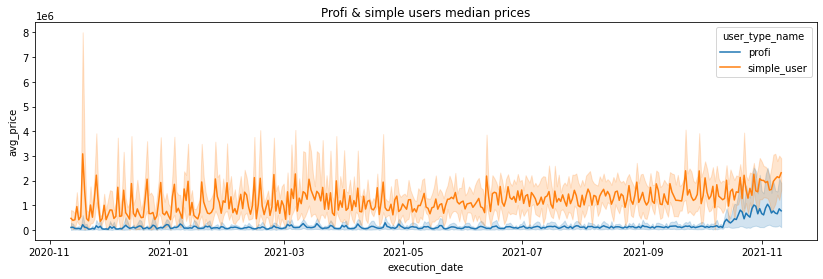

In [ ]:
fig, axes = plt.subplots(figsize=(14, 4))
sns.lineplot(data=df.query("user_type_name.isin(['profi', 'simple_user'])"), \
             x = 'execution_date',\
             y = 'avg_price', \
             hue = 'user_type_name', \
             estimator=np.mean).set_title('Profi & simple users median prices');

Данный график показывает, что цены у simple users в среднем сильно выше, чем у profi продавцов

#### Кейс 2. Вопрос 2: Определить топ-5 марок, продающихся быстрее всего, и топ-5 марок, продающихся медленнее всего.

In [ ]:
sql = f"""
SELECT
  advert_id,
  user_id,
  mark,
  model,
  min(min_date) as min_date,
  max(max_date) as max_date,
  min(min_price) as min_price,
  max(max_price) as max_price,
  avgMerge(mean_price) as mean_price
FROM {database_rw}.{prj_main_agg_view_2}
GROUP BY
  advert_id,
  user_id,
  mark,
  model
"""
result, columns = client_rw.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
df.head()

,advert_id,user_id,mark,model,min_date,max_date,min_price,max_price,mean_price
0,245169368,137326871,None,None,2020-11-16,2021-11-06,5600.0,8400.0,6.867568e+03
1,269240591,124477249,None,None,2021-10-14,2021-11-08,56000.0,56000.0,5.600000e+04
2,265449756,146397691,None,None,2021-07-22,2021-11-11,10000.0,10000.0,1.000000e+04
3,266809179,146082427,None,None,2021-08-21,2021-11-06,4000.0,4000.0,4.000000e+03
4,269593660,146236259,Mercedes-Benz,G-Класс,2021-10-23,2021-11-06,9300000.0,9300000.0,9.300000e+06


In [ ]:
# Отфильтруем строки, где mark None
df = df.loc[df['mark'].notna()]

In [ ]:
sql = f"""
SELECT mark, avg(days_diff) as avg_days_diff FROM (
SELECT
mark, advert_id,
(max(max_date) - min(min_date)) days_diff
FROM {database_rw}.{prj_main_agg_view_2}
WHERE mark is not Null
GROUP BY
mark, advert_id
 )
GROUP BY mark
ORDER BY avg_days_diff
"""
result, columns = client_rw.execute(sql, with_column_types=True)
pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

,mark,avg_days_diff
0,Aro,1.000000
1,SEAT,3.500000
2,Datsun,7.000000
3,DongFeng,10.500000
4,Alfa Romeo,14.000000
...,...,...
85,MG,176.750000
86,Great Wall,183.800000
87,Rover,195.000000
88,Scion,213.000000


Ответ:
1. Aro, SEAT, Datsun, DongFeng, Alfa Romeo
2. Ретро-автомобили, Scion, Rover, Great Wall, MG

#### Кейс 2. Вопрос 3: Определите, какую долю объявлений от общей базы составляют эти группы (суммарно ТОП-5 марок, продающихся быстрее всего и ТОП-5 марок, продающихся медленнее всего). ####

In [ ]:
sql = f"""
WITH first_5_last_5_marks AS (
SELECT mark FROM (
SELECT
  mark,
  advert_id,
  (max(max_date) - min(min_date)) days_diff
FROM {database_rw}.{prj_main_agg_view_2}
WHERE mark is not Null
GROUP BY
  mark,
  advert_id )
GROUP BY mark
ORDER BY avg(days_diff)
LIMIT 5
UNION ALL
SELECT mark FROM (
SELECT
  mark,
  advert_id,
  (max(max_date) - min(min_date)) days_diff
FROM {database_rw}.{prj_main_agg_view_2}
WHERE mark is not Null
GROUP BY
  mark,
  advert_id )
GROUP BY mark
ORDER BY avg(days_diff) DESC
LIMIT 5)

SELECT
  uniqExactIf(advert_id, (mark in (SELECT mark from first_5_last_5_marks)))/uniqExact(advert_id) * 100 as advert_ratio
FROM {database_rw}.{prj_main}
"""
result, columns = client_rw.execute(sql, with_column_types=True)
pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

,advert_ratio
0,0.032579


#### Кейс 2. Вопрос 4: Определите, какую долю пользователей от общего количества листеров составляют эти группы (суммарно ТОП-5 марок, продающихся быстрее всего и ТОП-5 марок, продающихся медленнее всего).

In [ ]:
sql = f"""
WITH first_5_last_5_marks AS (
SELECT mark FROM (
SELECT
  mark,
  advert_id,
  (max(max_date) - min(min_date)) days_diff
FROM {database_rw}.{prj_main_agg_view_2}
WHERE mark is not Null
GROUP BY
 mark,
 advert_id )
GROUP BY mark
ORDER BY avg(days_diff)
LIMIT 5
UNION ALL
SELECT mark FROM (
SELECT
  mark,
  advert_id,
  (max(max_date) - min(min_date)) days_diff
FROM {database_rw}.{prj_main_agg_view_2}
WHERE mark is not Null
GROUP BY
  mark,
  advert_id )
GROUP BY mark
ORDER BY avg(days_diff) DESC
LIMIT 5)

SELECT
  uniqIf(user_id, (mark in (SELECT mark from first_5_last_5_marks))) / (uniq(user_id)) * 100 as percent
FROM {database_rw}.{prj_main}
"""
result, columns = client_rw.execute(sql, with_column_types=True)
pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

,percent
0,0.177406


#### Кейс 3. Вопрос 5: Как изменилось время ухода объявлений в архив за полгода? ####
Cравнить время ухода объявления в архив по когорте объявлений, появившихся в период с 1 декабря 2020 по 1 января 2021 с временем ухода в архив для когорты объявлений, появившихся с 1 июня 2021 по 1 июля 2021.

In [ ]:
# Посчитаем время ухода в архив для всех объявлений и построим график.
#Здесь нужно учитывать, что многие объявления все еще активны на последнюю дату и мы увидим "Ошибку выжившего" - чем ближе к последней дате, тем "быстрее" закрываются объявления
sql = f"""
SELECT
  min(min_date) as date,
  max(max_date) - min(min_date) as days_diff
FROM
{database_rw}.{prj_main_agg_view_3}
GROUP BY
  user_type_name,
  mark,
  advert_id
HAVING max(max_date) <  (SELECT max(execution_date) FROM {database_rw}.{prj_main}) --and toYYYYMM(min(min_date)) in [202012, 202106]
"""
result, columns = client_rw.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
# Посмотрим на процент незакрытых на последнюю дату объявлений в каждом месяце
sql = f"""
WITH ads as (SELECT
  advert_id,
  min(min_date) as date,
  max(max_date) as max_date,
  toStartOfMonth(date) as cohort
FROM
{database_rw}.{prj_main_agg_view_3}
GROUP BY
  user_type_name,
  mark,
  advert_id)

SELECT
cohort, round((countIf(max_date = (SELECT max(execution_date) FROM {database_rw}.{prj_main})) / count(advert_id)) * 100, 2) as percent_open
FROM ads
GROUP BY cohort
"""
result, columns = client_rw.execute(sql, with_column_types=True)
df1 = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
# Построим гистограмму, чтобы увидеть распределение длительности жизни объявлений, открытых в декабрьскую и июньскую когорты
sql = f"""
SELECT
  toStartOfMonth(min(min_date)) as cohort,
  max(max_date) - min(min_date) as days_diff
FROM
{database_rw}.{prj_main_agg_view_3}
GROUP BY
  user_type_name,
  mark,
  advert_id
HAVING max(max_date) <  (SELECT max(execution_date) FROM {database_rw}.{prj_main}) and toYYYYMM(min(min_date)) in [202012, 202106]
"""
result, columns = client_rw.execute(sql, with_column_types=True)
df2 = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

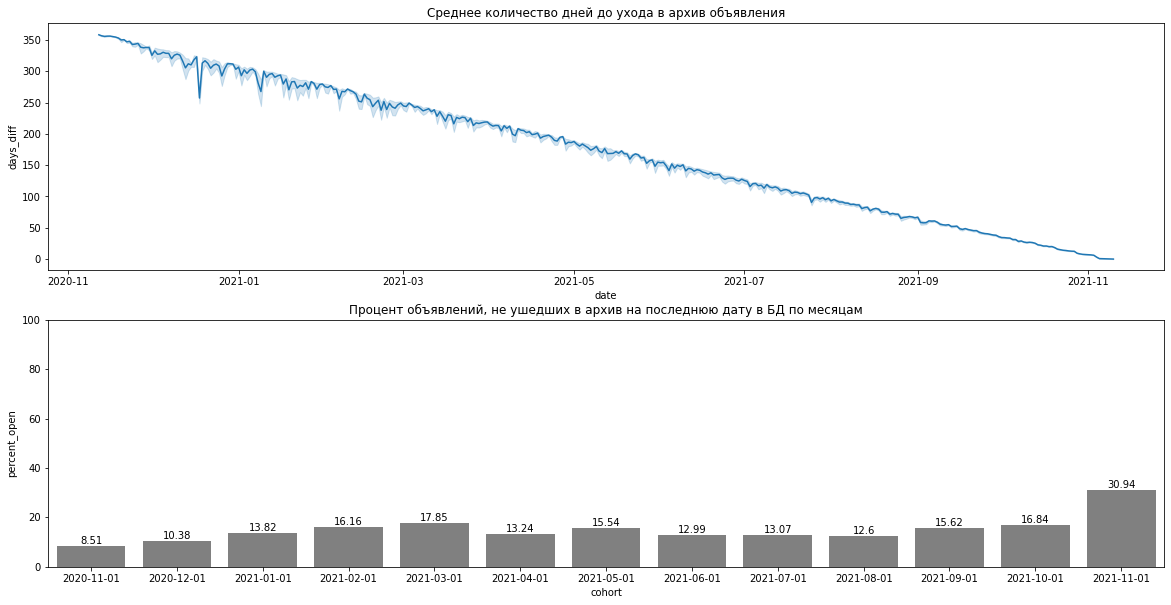

In [ ]:
fig, axes = plt.subplots(figsize=(20, 10), nrows = 2)
sns.lineplot(data=df, x = 'date', y = 'days_diff', ax = axes[0]).set_title('Среднее количество дней до ухода в архив объявления')
sns.barplot(data=df1, x = 'cohort', y = 'percent_open', color = 'grey', ax = axes[1], errwidth=0).set_title('Процент объявлений, не ушедших в архив на последнюю дату в БД по месяцам')
axes[1].set(ylim=(0, 100));
for i in axes[1].containers:
    axes[1].bar_label(i)
plt.show()

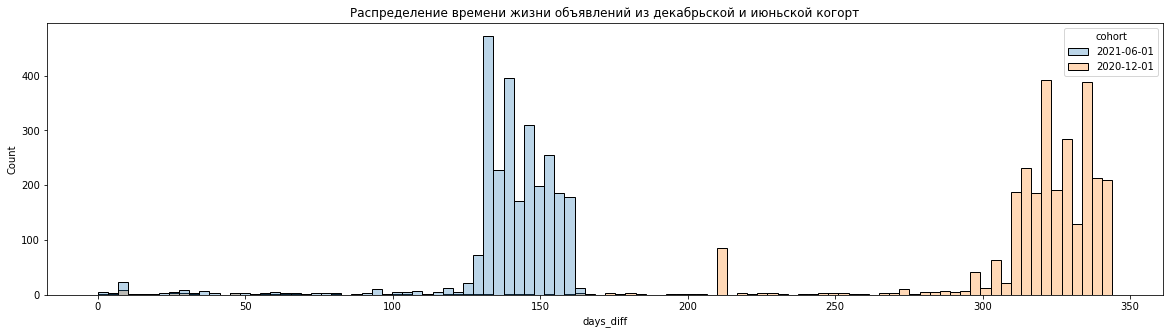

In [ ]:
fig, axes = plt.subplots(figsize=(20, 5))
sns.histplot(data=df2, x = 'days_diff', hue='cohort', bins = 100, alpha = 0.3).set_title('Распределение времени жизни объявлений из декабрьской и июньской когорт');

Из последнего графика можно сделать вывод, что время ухода объявлений в архив уменьшилось

#### Кейс 3. Вопрос 6: На сколько дней изменилось среднее время ухода в архив в июньской когорте относительно декабрьской когорты? ####

In [ ]:
df2.groupby('cohort')['days_diff'].mean().diff()

cohort
2020-12-01           NaN
2021-06-01   -176.575945
Name: days_diff, dtype: float64

Уменьшилось на 177 дней

#### Кейс 3. Вопрос 7: По каким маркам время ухода в архив выросло больше всего между декабрьской и июньской когортами? ####

In [ ]:
# Воспользуемся оконной функцией lagInFrame и посчитаем разницу в днях между декабрьской и июньской когортами внутри партиции mark
sql = f"""
SELECT mark,  cohort_days_diff - avg_days_diff as diff FROM (
SELECT
  mark,
  cohort,
  avg(days_diff) as avg_days_diff,
  lagInFrame(avg_days_diff) OVER (
    PARTITION BY mark
    ORDER BY
      cohort ROWS BETWEEN 1 PRECEDING
      AND 1 FOLLOWING
  ) as cohort_days_diff
FROM
  (
    SELECT
      mark,
      toStartOfMonth(min(min_date)) as cohort,
      (max(max_date) - min(min_date)) days_diff
    FROM
      { database_rw }.{ prj_main_agg_view_2 }
    WHERE
      mark is not Null
    GROUP BY
      mark,
      advert_id
    HAVING
      toYYYYMM(min(min_date)) in [202012, 202106]
  )
GROUP BY
  mark,
  cohort
)
WHERE cohort_days_diff > 0
ORDER BY
  diff
"""
result, columns = client_rw.execute(sql, with_column_types=True)
df3 = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
df3.head()

,mark,diff
0,Renault,-107.000000
1,Honda,59.342857
2,Lexus,100.928571
3,Subaru,104.000000
4,Toyota,116.428638


Время ухода в архив выросло только у Renault

#### Кейс 3. Вопрос 8: У каких пользователей изменение времени продажи выше? ####
На этот вопрос нам поможет ответить Boxplot

In [ ]:
sql = f"""
SELECT
  user_type_name,
  toStartOfMonth(min(min_date)) as cohort,
  max(max_date) - min(min_date) as days_diff
FROM
{database_rw}.{prj_main_agg_view_3}
GROUP BY
  user_type_name,
  mark,
  advert_id
HAVING max(max_date) <  (SELECT max(execution_date) FROM {database_rw}.{prj_main}) and toYYYYMM(min(min_date)) in [202012, 202106]
"""
result, columns = client_rw.execute(sql, with_column_types=True)
df4 = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

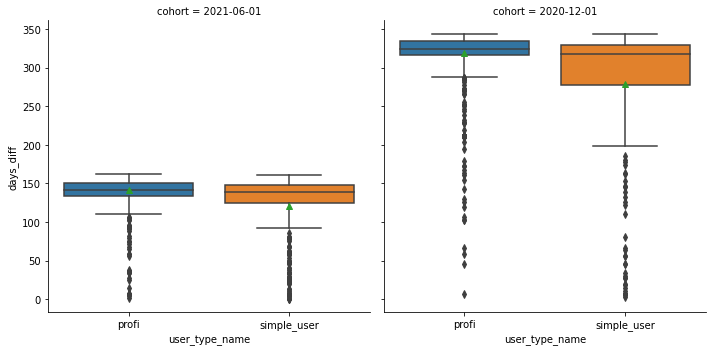

In [ ]:
sns.catplot(x='user_type_name',y='days_diff', data=df4, kind='box',col='cohort', showmeans=True);

У категории profi разница между средними значениями в когортах больше, чем у simple user